In [14]:
import numpy as np

def chunks(file_path, chunk_size=1000):
    data = np.load(file_path, mmap_mode='r')
    num_chunks = data.shape[0] // chunk_size
    for i in range(num_chunks + 1):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, data.shape[0])
        if start_idx < end_idx:
            yield data[start_idx:end_idx]

data1_chunks = chunks(r"C:\Users\user\OneDrive\Desktop\vs\ML4DQM\Run355456_Dataset.npy", chunk_size=1000)
data2_chunks = chunks(r"C:\Users\user\OneDrive\Desktop\vs\ML4DQM\Run357479_Dataset.npy", chunk_size=1000)


(1000, 64, 72)
(1000, 64, 72)


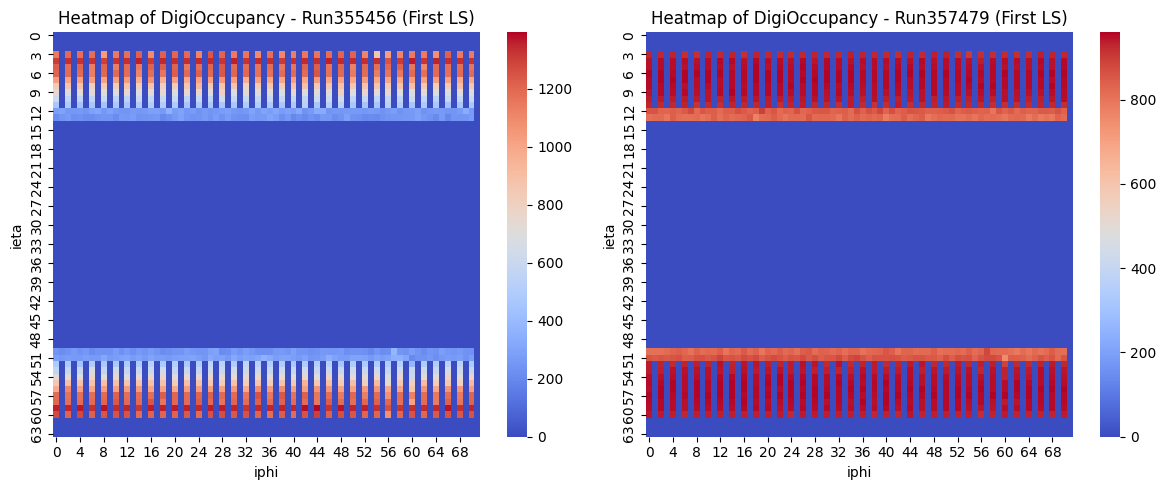

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

data1 = next(data1_chunks)  # Get the first chunk from the generator
data2 = next(data2_chunks)

print(data1.shape)
print(data2.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(data1[0], cmap="coolwarm")  # First LS from the first chunk
plt.title("Heatmap of DigiOccupancy - Run355456 (First LS)")
plt.xlabel("iphi")
plt.ylabel("ieta")

plt.subplot(1, 2, 2)
sns.heatmap(data2[0], cmap="coolwarm")
plt.title("Heatmap of DigiOccupancy - Run357479 (First LS)")
plt.xlabel("iphi")
plt.ylabel("ieta")

plt.tight_layout()
plt.show()


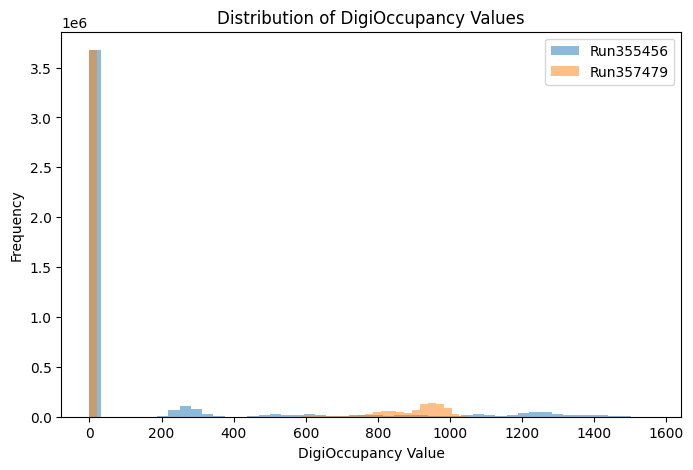

In [16]:

plt.figure(figsize=(8, 5))
plt.hist(data1.flatten(), bins=50, alpha=0.5, label="Run355456")
plt.hist(data2.flatten(), bins=50, alpha=0.5, label="Run357479")
plt.title("Distribution of DigiOccupancy Values")
plt.xlabel("DigiOccupancy Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [17]:
def zero_percentage(dataset):
    total_elements = dataset.size
    zero_count = np.sum(dataset == 0)
    return (zero_count / total_elements) * 100

print("Zeros in Run355456:", zero_percentage(data1), "%")
print("Zeros in Run357479:", zero_percentage(data2), "%")


Zeros in Run355456: 79.77430555555556 %
Zeros in Run357479: 79.77430555555556 %


Normalizing DigiOccupany values for better training

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data1_scaled = scaler.fit_transform(data1.reshape(-1, 1)).reshape(data1.shape)
data2_scaled = scaler.fit_transform(data2.reshape(-1, 1)).reshape(data2.shape)

In [19]:
data1_scaled = data1_scaled[..., np.newaxis]  
data2_scaled = data2_scaled[..., np.newaxis]

print(data1_scaled.shape)
print(data2_scaled.shape)

(1000, 64, 72, 1)
(1000, 64, 72, 1)


In [20]:
import numpy as np

labels1 = np.zeros(data1_scaled.shape[0])  # Run355456 -> Label 0
labels2 = np.ones(data2_scaled.shape[0])   # Run357479 -> Label 1


In [21]:
X = np.concatenate([data1_scaled, data2_scaled], axis=0)
y = np.concatenate([labels1, labels2], axis=0)


Train,Test,Val split (70-15-15)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)


(1400, 64, 72, 1) (300, 64, 72, 1) (300, 64, 72, 1)


In [23]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)

X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.int32)

X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)

y_train_tf = to_categorical(y_train_tf, num_classes=2)
y_val_tf = to_categorical(y_val_tf, num_classes=2)




Augmentation (random rotation and flipping) done on training set

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

Patch extraction

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

input_shape = (72, 64, 1)
inputs = layers.Input(shape=input_shape)

patch_size = 8
patch_height, patch_width = patch_size, patch_size

num_patches_h = input_shape[0] // patch_height
num_patches_w = input_shape[1] // patch_width
num_patches = num_patches_h * num_patches_w

patch_dim = patch_height * patch_width * input_shape[-1]
patches = layers.Conv2D(filters=64, kernel_size=(patch_height, patch_width),
                         strides=(patch_height, patch_width), padding="valid")(inputs)

patches = layers.Reshape((num_patches, 64))(patches)

print("Patch Shape:", patches.shape)


Patch Shape: (None, 72, 64)


Positional encoding for model to recognize **order of patches**

In [ ]:
import numpy as np

def get_positional_encoding(num_patches, d_model):
    positions = np.arange(num_patches)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((num_patches, d_model))
    pos_enc[:, 0::2] = np.sin(positions * div_term)
    pos_enc[:, 1::2] = np.cos(positions * div_term)
    return tf.cast(pos_enc, dtype=tf.float32)

pos_encoding = get_positional_encoding(num_patches, 64)
patches_with_pos = layers.Add()([patches, pos_encoding])

pos_encoding = tf.expand_dims(pos_encoding, axis=0)
patches_with_pos = layers.Add()([patches, pos_encoding])

print("Positional Encoding Shape:", pos_encoding.shape)
print("Patches with Positional Encoding Shape:", patches_with_pos.shape)


Positional Encoding Shape: (1, 72, 64)
Patches with Positional Encoding Shape: (1, 72, 64)


Encoder block setup (Multi head attention + FFN MLP)

In [ ]:

# from tensorflow.keras import regularizers

# def transformer_encoder_block(x, num_heads, d_model, mlp_dim, dropout_rate=0.3):

#     attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
#     attn_output = layers.Dropout(dropout_rate)(attn_output)
#     attn_output = layers.Add()([attn_output, x])
#     attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output)
#     attn_output = layers.Dropout(dropout_rate)(attn_output)


#     ffn_output = layers.Dense(mlp_dim, activation="relu",kernel_regularizer=regularizers.l2(1e-4))(attn_output)
#     ffn_output = layers.Dropout(dropout_rate)(ffn_output)
#     ffn_output = layers.Dense(d_model,kernel_regularizer=regularizers.l2(1e-4))(ffn_output)
#     ffn_output = layers.Dropout(dropout_rate)(ffn_output)
#     ffn_output = layers.Add()([ffn_output, attn_output])
#     return layers.LayerNormalization(epsilon=1e-6)(ffn_output)


# num_layers = 4   
# num_heads = 4    
# mlp_dim = 128  
# d_model = 64 


# x = patches_with_pos
# for _ in range(num_layers):
#     x = transformer_encoder_block(x, num_heads, d_model, mlp_dim)

# print("Transformer Output Shape:", x.shape)


Transformer Output Shape: (1, 72, 64)


Model summary

In [ ]:
#representation = layers.GlobalAveragePooling1D()(x)
#num_classes = 2

#outputs = layers.Dense(num_classes, activation="softmax")(representation)

#vit_model = Model(inputs, outputs)
#vit_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 8, 64)  │      4,160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 72, 64)    │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 72, 64)       │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 72, 64)       │     66,368 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (1, 72, 64)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 72, 64)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (1, 72, 64)       │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (1, 72, 128)      │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (1, 72, 128)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, 72, 64)       │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (1, 72, 64)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (1, 72, 64)       │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 72, 64)       │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 72, 64)       │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (1, 72, 64)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (1, 72, 64)       │          0 │ dropout_5[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 72, 64)       │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, 72, 128)      │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (1, 72, 128)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 337,090 (1.29 MB)

 Trainable params: 337,090 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
X_train_tf = tf.reshape(X_train_tf, [-1, 72, 64, 1])
X_val_tf = tf.reshape(X_val_tf, [-1, 72, 64, 1])
X_test_tf = tf.reshape(X_test_tf, [-1, 72, 64, 1])



In [25]:
print(X_train_tf.shape, y_train_tf.shape)
print(X_val_tf.shape, y_val_tf.shape)


(1400, 72, 64, 1) (1400, 2)
(300, 72, 64, 1) (300, 2)


In [ ]:
# vit_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #using Adam optimizer,n=1e-4,crossentropy loss function
#     loss="categorical_crossentropy", 
#     metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
# )


In [ ]:
#history = vit_model.fit(
#    X_train_tf, y_train_tf,
#    validation_data=(X_val_tf, y_val_tf),
#    epochs=20,
#    batch_size=32
#)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.5410 - auc: 0.5494 - loss: 0.8045 - val_accuracy: 0.5100 - val_auc: 0.7599 - val_loss: 0.7075
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.6326 - auc: 0.6922 - loss: 0.7242 - val_accuracy: 0.9967 - val_auc: 0.9999 - val_loss: 0.5053
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9795 - auc: 0.9903 - loss: 0.4899 - val_accuracy: 0.9967 - val_auc: 1.0000 - val_loss: 0.0806
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9928 - auc: 0.9946 - loss: 0.1150 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0700
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9927 - auc: 0.9974 - loss: 0.0998 - val_accuracy: 0.9967 - val_auc: 0.9999 - val_loss: 0.0776
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9931 - auc: 0.9978 - loss: 0.1003 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0680
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms

In [ ]:
#from sklearn.metrics import classification_report, roc_auc_score
#import pandas as pd

#y_pred_prob = vit_model.predict(X_test_tf)
#y_pred_classes = (y_pred_prob[:, 1] > 0.5).astype("int32")

#report = classification_report(y_test_tf, y_pred_classes, output_dict=True)
#roc_auc = roc_auc_score(y_test_tf, y_pred_prob[:, 1])

#metrics_data = {
#    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"],
#    "Score": [
#        report["accuracy"],
#        report["1"]["precision"],
#        report["1"]["recall"],
#        report["1"]["f1-score"],
#        roc_auc
#    ]
#}

#metrics_df = pd.DataFrame(metrics_data)
#print(metrics_df.to_string(index=False))


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step
   Metric    Score
 Accuracy 0.996667
Precision 1.000000
   Recall 0.993377
 F1-Score 0.996678
  ROC-AUC 0.993377


In [ ]:
#vit_model.save("vit_model.keras")


In [ ]:
from tensorflow.keras.models import load_model

vit_model = load_model("vit_model.keras")
vit_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 8, 64)  │      4,160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 72, 64)    │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 72, 64)       │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 72, 64)       │     66,368 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (1, 72, 64)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 72, 64)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (1, 72, 64)       │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (1, 72, 128)      │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (1, 72, 128)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, 72, 64)       │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (1, 72, 64)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (1, 72, 64)       │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 72, 64)       │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 72, 64)       │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (1, 72, 64)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (1, 72, 64)       │          0 │ dropout_5[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 72, 64)       │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, 72, 128)      │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (1, 72, 128)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,011,272 (3.86 MB)

 Trainable params: 337,090 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 674,182 (2.57 MB)

Running model predictions on a test set (binary classification)

In [26]:
y_pred = vit_model.predict(X_test_tf)
y_pred_classes = (y_pred > 0.5).astype("int32")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


In [ ]:
import numpy as np
y_pred_classes = np.argmax(y_pred_classes, axis=1)


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np


print(classification_report(y_test_tf, y_pred_classes))
print(confusion_matrix(y_test_tf, y_pred_classes))

auc_score = roc_auc_score(y_test_tf, y_pred[:, 1])
print(f"ROC AUC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       1.00      0.99      1.00       151

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

[[149   0]
 [  1 150]]
ROC AUC Score: 0.9934
